In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, fbeta_score, roc_auc_score, confusion_matrix)
import warnings
warnings.filterwarnings('ignore')

X_train = pd.read_csv('../data/modeling/X_train.csv')
y_train = pd.read_csv('../data/modeling/y_train.csv').values.ravel()
X_test = pd.read_csv('../data/modeling/X_test.csv')
test_ids = pd.read_csv('../data/modeling/test_ids.csv')

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")

X_train: (7461, 62), y_train: (7461,)


### NOTE

  - False Positive (we reach out, they don't enroll): Low cost. We spend marginal outreach dollars on someone who says no. Minor resource waste.                                                                                                                    
            
  - False Negative (we skip them, but they would have enrolled): High cost. We permanently lose a potential enrollee who may never get another touchpoint. Lost revenue + missed program impact.
In this scenario, the cost of missing a likely enrollee far exceeds the cost of an extra phone call or mailer (this is MY ASSUMPTION...). We're not constrained by a tiny outreach budget (Assumption!!m) — we have 2,500 prospects and the capacity to contact them. The limiting factor isn't outreach cost, it's conversion.


F2 weights recall 2x higher than precision, which aligns with this asymmetry and we'd much rather cast a wider net and accept some wasted contacts than risk not contacting any enrolees to begin with

In [5]:
def cross_validate_model(model, X, y, n_splits=5, scale=False):
    """
    Run stratified k-fold CV and return metrics for each fold + averages.
    F2 score emphasizes recall (beta=2).
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    metrics = {
        'accuracy': [], 'precision': [], 'recall': [], 
        'f1': [], 'f2': [], 'auc': []
    }
    
    # aggregate confusion matrix across folds
    total_cm = np.zeros((2, 2))
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]
        
        if scale:
            scaler = StandardScaler()
            X_tr = scaler.fit_transform(X_tr)
            X_val = scaler.transform(X_val)
        
        model.fit(X_tr, y_tr)
        y_pred = model.predict(X_val)
        y_prob = model.predict_proba(X_val)[:, 1] if hasattr(model, 'predict_proba') else y_pred
        
        metrics['accuracy'].append(accuracy_score(y_val, y_pred))
        metrics['precision'].append(precision_score(y_val, y_pred))
        metrics['recall'].append(recall_score(y_val, y_pred))
        metrics['f1'].append(f1_score(y_val, y_pred))
        metrics['f2'].append(fbeta_score(y_val, y_pred, beta=2))
        metrics['auc'].append(roc_auc_score(y_val, y_prob))
        total_cm += confusion_matrix(y_val, y_pred)
    
    return metrics, total_cm.astype(int)


def print_cv_results(name, metrics):
    """Print mean and std for each metric."""
    print(f"{name}")
    print(f"{'Metric':<12} {'Mean':>10} {'Std':>12}")
    for metric, values in metrics.items():
        mean, std = np.mean(values), np.std(values)
        print(f"{metric:<12} {mean:>10.4f}(+/- {std:.4f})")
    print(f"\nF2 Score: {np.mean(metrics['f2']):.4f} **\n")
    return np.mean(metrics['f2'])

In [6]:
# define models here. I'm going with Logistic Regression, Random Forest, XGBoost, and SVM classifiers only. 
models = {
    'Logistic Regression': (LogisticRegression(max_iter=1000, random_state=42), True),
    'Random Forest': (RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42), False),
    'XGBoost': (XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                              random_state=42, eval_metric='logloss'), False),
    'SVM (RBF)': (SVC(kernel='rbf', probability=True, random_state=42), True),
}

In [7]:
# run 5-fold CV for each model
results = {}

for name, (model, needs_scaling) in models.items():
    print(f"\nTraining {name}...")
    metrics, cm = cross_validate_model(model, X_train, y_train, n_splits=5, scale=needs_scaling)
    f2 = print_cv_results(name, metrics)
    results[name] = {'metrics': metrics, 'f2': f2, 'confusion_matrix': cm}


Training Logistic Regression...
Logistic Regression
Metric             Mean          Std
accuracy         0.6680(+/- 0.0100)
precision        0.6667(+/- 0.0067)
recall           0.6601(+/- 0.0230)
f1               0.6632(+/- 0.0140)
f2               0.6613(+/- 0.0193)
auc              0.7362(+/- 0.0126)

F2 Score: 0.6613 **


Training Random Forest...
Random Forest
Metric             Mean          Std
accuracy         0.6629(+/- 0.0139)
precision        0.6671(+/- 0.0114)
recall           0.6379(+/- 0.0265)
f1               0.6521(+/- 0.0187)
f2               0.6435(+/- 0.0234)
auc              0.7295(+/- 0.0148)

F2 Score: 0.6435 **


Training XGBoost...
XGBoost
Metric             Mean          Std
accuracy         0.6671(+/- 0.0140)
precision        0.6754(+/- 0.0136)
recall           0.6317(+/- 0.0202)
f1               0.6528(+/- 0.0164)
f2               0.6400(+/- 0.0187)
auc              0.7344(+/- 0.0134)

F2 Score: 0.6400 **


Training SVM (RBF)...
SVM (RBF)
Metric             

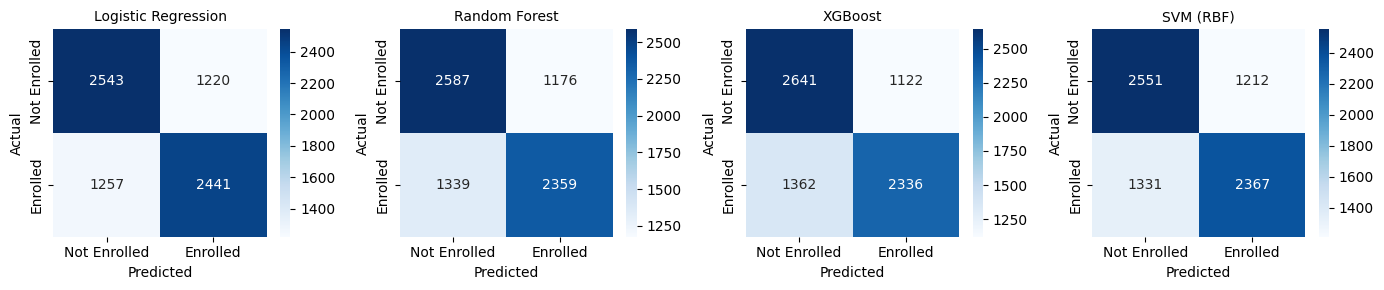

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# sort results by F2
sorted_results = sorted(results.items(), key=lambda x: x[1]['f2'], reverse=True)

# plot confusion matrices
fig, axes = plt.subplots(1, 4, figsize=(14, 3))

for ax, (name, data) in zip(axes, results.items()):
    cm = data['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Not Enrolled', 'Enrolled'],
                yticklabels=['Not Enrolled', 'Enrolled'])
    ax.set_title(name, fontsize=10)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

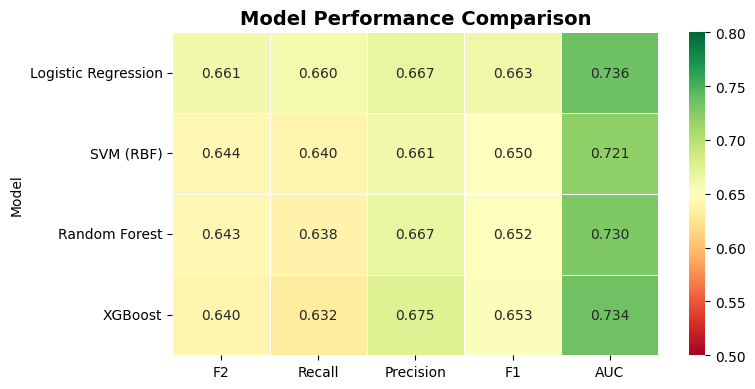


Best model by F2: Logistic Regression


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# build comparison dataframe
comparison = pd.DataFrame({
    'Model': [name for name, _ in sorted_results],
    'F2': [np.mean(data['metrics']['f2']) for _, data in sorted_results],
    'Recall': [np.mean(data['metrics']['recall']) for _, data in sorted_results],
    'Precision': [np.mean(data['metrics']['precision']) for _, data in sorted_results],
    'F1': [np.mean(data['metrics']['f1']) for _, data in sorted_results],
    'AUC': [np.mean(data['metrics']['auc']) for _, data in sorted_results],
}).set_index('Model')

# heatmap
fig, ax = plt.subplots(figsize=(8, 4))
sns.heatmap(comparison, annot=True, fmt='.3f', cmap='RdYlGn', 
            linewidths=0.5, ax=ax, vmin=0.5, vmax=0.8)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nBest model by F2: {comparison['F2'].idxmax()}")